# TM10007 Assignment group 4 - ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git
#!pip install git+https://github.com/rinikerlab/GHOST

import zipfile
import os
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Import Support Vector Classifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

missing_values = data.isna().any().any()

if missing_values:
    print("There are missing values in the DataFrame.")
else:
    print("There are no missing values in the DataFrame.")


fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001
There are no missing values in the DataFrame.


In [ ]:
from scipy.stats import shapiro

# Assuming 'data' is your dataset
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.040, p=0.000
Sample does not look Gaussian (reject H0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Plot data

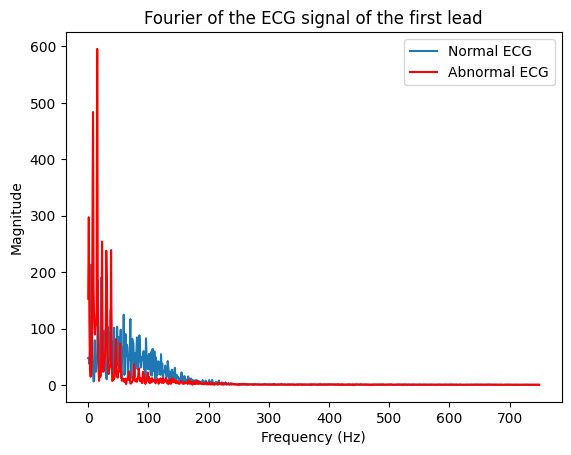

In [ ]:
import matplotlib.pyplot as plt

# Create a time index ranging from 0 to 749 seconds
time_index = range(750)  # Assuming the index starts from 0

# Extract values for the second patient (assuming row index 1 corresponds to the second patient)
patient_values = data.iloc[0]  # Change the index if the second patient is at a different row
patient_valuess = data.iloc[1]

# Plot values for the second patient against the time index
plt.plot(time_index, patient_values[0:750], label='Normal ECG')
plt.plot(time_index, patient_valuess[0:750], 'r', label='Abnormal ECG')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier of the ECG signal of the first lead')
plt.legend()

# Show plot
plt.show()


In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scikit_learn-1.2.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/sklearn/*
Proceed (Y/n)? Ý
Your response ('ý') was not one of the expected responses: y, n, 
Proceed (Y/n)? Y
  Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 24.4 MB/s eta 0:00:00


#Pre-processing

In [ ]:

!pip install -q --force-reinstall scikit-optimize

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Import Support Vector Classifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif

#from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


np.random.seed(42)
tf.random.set_seed(42)

# Split the dataset into training and testing sets
df_temp, df_test = train_test_split(data, test_size=0.2, random_state=42)

# Separate sick and healthy patients
sick_patients = df_temp[df_temp['label'] == 1]
healthy_patients = df_temp[df_temp['label'] == 0]

# Randomly select 3 times the amount of sick patients
healthy_sample = healthy_patients.sample(n=3*len(sick_patients), random_state=42)

# Combine sick and healthy samples
sorted_data = pd.concat([sick_patients, healthy_sample])

# Shuffle the DataFrame to mix the order of samples
df_temp_s = sorted_data.sample(frac=1, random_state=42).reset_index(drop=True)
#print(sorted_data)
one = sorted_data['label'].value_counts().get(1, 0)
zero = sorted_data['label'].value_counts().get(0, 0)
print(one)
print(zero)

#df_temp_s = shuffle(df_temp_s, random_state=42)
#df_train, df_val = train_test_split(df_temp_s, test_size=0.25, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

x_train = df_train.drop(columns=['label'])
# Fit the scaler on the DataFrame and transform it
x_train_scaled = scaler.fit_transform(x_train.values)
# Convert the scaled numpy array back to a DataFrame
x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)

y_train = df_train['label']

x_test = df_test.drop(columns=['label'])
# transform it
x_test_scaled = scaler.transform(x_test.values)
# Convert the scaled numpy array back to a DataFrame
x_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)

y_test = df_test['label']

x_val = df_val.drop(columns=['label'])
# transform it
x_val_scaled = scaler.transform(x_val.values)
# Convert the scaled numpy array back to a DataFrame
x_val = pd.DataFrame(x_val_scaled, columns=x_val.columns)

y_val = df_val['label']

selector = SelectKBest(score_func=f_classif, k=400)
selector.fit(x_train, y_train)
x_train_selected = selector.transform(x_train)
x_val_selected = selector.transform(x_val)

#y_val_counts = y_val.value_counts()
#print(y_val_counts)

#y_train_counts = y_train.value_counts()
#print(y_train_counts)

#y_test_counts = y_test.value_counts()
#print(y_test_counts)


118
354


#Linear SVC
A linear SVC was used to classify the binary dataset. The accuracy was 0.75, not near the required 0.85.  

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Perform grid search
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5)
grid_search.fit(x_train_selected, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

x_test_selected = selector.transform(x_test)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test_selected)

# Evaluate accuracy of the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy (Best Model):", accuracy_best)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: Futu

Best Parameters: {'C': 0.01}
Accuracy (Best Model): 0.7590361445783133


#k-nearest neighbors
A k-nearest neighbors model was also used to classify the binary dataset. The accuracy was 0.84, close to the required 0.85.  

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define a dictionary of hyperparameters to test
param_grid_knn = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12],  # Test different values for the number of neighbors
    'weights': ['uniform', 'distance'],  # Test different weight options
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Test different algorithms
}

# Create a KNN classifier instance
knn = KNeighborsClassifier()

# Instantiate GridSearchCV with the KNN classifier and the parameter grid
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search_knn.fit(x_train_selected, y_train)

# Get the best hyperparameters found by GridSearchCV
best_param_knn = grid_search_knn.best_params_
print("Best Hyperparameters:", best_param_knn)

# Get the best model
best_model_knn = grid_search_knn.best_estimator_

x_test_selected = selector.transform(x_test)

# Evaluate the best model on the test set
accuracy = best_model_knn.score(x_test_selected, y_test)
print("Accuracy:", accuracy)

print(y_test.value_counts())

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7cab80e15750>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1014, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1184, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 113, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function Thread

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy: 0.8433734939759037
label
0    138
1     28
Name: count, dtype: int64


#Ensembling a deep neural network, random forest and support vector machine with StratifiedKFold


In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

mlp = MLPClassifier(
        hidden_layer_sizes=(100),
        alpha=0.01,
        random_state=1,
        learning_rate_init=0.001,
        early_stopping=False,
        max_iter=100,
        activation='logistic',)

param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],  # Various hidden layer sizes
    'alpha': uniform(0, 0.1),  # L2 penalty (regularization term) parameter
    'learning_rate_init': uniform(0.0001, 0.001),  # Initial learning rate
    'activation': ['logistic', 'relu'],  # Activation functions for the hidden layers
    'max_iter': randint(30, 200),  # Maximum number of iterations
}

param_dist_rf = {
    'n_estimators': np.random.randint(10, 1000, size=10),
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': np.random.randint(2, 20, size=10),
    'min_samples_leaf': np.random.randint(1, 20, size=10),
    'max_features': ['auto', 'sqrt']
}

# Define the parameter space for SVM
param_dist_svm = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}


rf_model = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1
)


svm_model = RandomizedSearchCV(
    estimator=SVC(probability=True),
    param_distributions=param_dist_svm,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1
)


mlp_model = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist_mlp,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1
)

# Perform K-fold cross-validation
num_folds = 5

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, val_index in stratified_kfold.split(x_train_selected, y_train):
    x_train_k, x_val_k = x_train_selected[train_index], x_train_selected[val_index]
    y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[val_index]

    mlp_model.fit(x_train_k, y_train_k)

    # Train the Random Forest model
    rf_model.fit(x_train_k, y_train_k)

    # Train the Support Vector Machine model
    svm_model.fit(x_train_k, y_train_k)

    # Generate predictions from all models
    dnn_predictions = mlp_model.predict(x_val_k)
    rf_predictions = rf_model.predict_proba(x_val_k)[:, 1]
    svm_predictions = svm_model.predict_proba(x_val_k)[:, 1]


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


#Ensembling

In [ ]:
import numpy as np

dnn_predictions_train = mlp_model.predict(x_train_selected)
rf_predictions_train = rf_model.predict_proba(x_train_selected)[:, 1]
svm_predictions_train = svm_model.predict_proba(x_train_selected)[:, 1]

ensemble_predictions = np.column_stack((dnn_predictions_train, rf_predictions_train, svm_predictions_train))
final_predictions = np.sum(ensemble_predictions, axis=1) >= 2
final_predictions = final_predictions.astype(int)

ensemble_acc = np.mean(final_predictions == y_train)
print("Ensemble Accuracy:", ensemble_acc)


mlp_accuracy = mlp_model.score(x_train_selected,y_train)
print("DNN Accuracy:", mlp_accuracy)

rf_accuracy = rf_model.score(x_train_selected,y_train)
print("RF Accuracy:", rf_accuracy)

svm_accuracy = svm_model.score(x_train_selected,y_train)
print("SVM Accuracy:", svm_accuracy)


Ensemble Accuracy: 0.9378531073446328
DNN Accuracy: 0.943502824858757
RF Accuracy: 0.9096045197740112
SVM Accuracy: 0.943502824858757


#Test accuracy

In [ ]:
x_test_selected = selector.transform(x_test)

# Generate predictions on the test set using all models
dnn_predictions_test = mlp_model.predict(x_test_selected)
rf_predictions_test = rf_model.predict_proba(x_test_selected)[:, 1]
svm_predictions_test = svm_model.predict_proba(x_test_selected)[:, 1]

ensemble_predictions = np.column_stack((dnn_predictions_test, rf_predictions_test, svm_predictions_test))
final_predictions = np.sum(ensemble_predictions, axis=1) >= 2
final_predictions = final_predictions.astype(int)

ensemble_acc_test = np.mean(final_predictions == y_test)
print('Ensemble Accuracy Test:', ensemble_acc_test)

val_count = y_test.value_counts()
print(val_count)


df = pd.DataFrame({
    'Column1': dnn_predictions_test,
    'Column2': rf_predictions_test,
    'Column3': svm_predictions_test,
    'final': final_predictions,
    'Series': y_test
})

pd.set_option('display.max_rows', None)
#print(df)

mlp_accuracy_test = mlp_model.score(x_test_selected,y_test)
print("DNN Accuracy:", mlp_accuracy_test)

rf_accuracy_test = rf_model.score(x_test_selected,y_test)
print("RF Accuracy:", rf_accuracy_test)

svm_accuracy_test = svm_model.score(x_test_selected,y_test)
print("SVM Accuracy:", svm_accuracy_test)

Ensemble Accuracy Test: 0.8493975903614458
label
0    138
1     28
Name: count, dtype: int64
DNN Accuracy: 0.8072289156626506
RF Accuracy: 0.8554216867469879
SVM Accuracy: 0.7771084337349398


#find best learning rate


Learning rate for epoch 0 is 0.0010000000474974513

Learning rate for epoch 1 is 0.0010000000474974513

Learning rate for epoch 2 is 0.0010000000474974513

Learning rate for epoch 3 is 0.0010000000474974513

Learning rate for epoch 4 is 0.0010000000474974513

Learning rate for epoch 5 is 0.0010000000474974513

Learning rate for epoch 6 is 0.0010000000474974513

Learning rate for epoch 7 is 0.0010000000474974513

Learning rate for epoch 8 is 0.0010000000474974513

Learning rate for epoch 9 is 0.0010000000474974513

Learning rate for epoch 10 is 0.0010000000474974513

Learning rate for epoch 11 is 0.0010000000474974513

Learning rate for epoch 12 is 0.0010000000474974513

Learning rate for epoch 13 is 0.0010000000474974513

Learning rate for epoch 14 is 0.0010000000474974513

Learning rate for epoch 15 is 0.0010000000474974513

Learning rate for epoch 16 is 0.0010000000474974513

Learning rate for epoch 17 is 0.0010000000474974513

Learning rate for epoch 18 is 0.0010000000474974513

Le

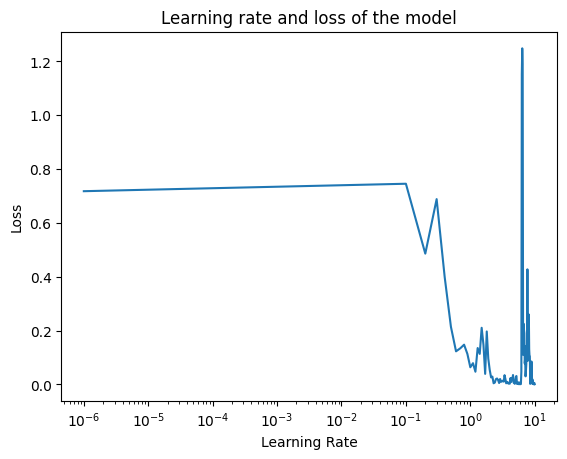

In [ ]:
from keras.callbacks import LambdaCallback
import numpy as np
import matplotlib.pyplot as plt

# Define the learning rate range test function
def lr_range_test(start_lr, end_lr, num_steps):
    """
    Performs a learning rate range test as described by Leslie N. Smith.

    Args:
        start_lr (float): The starting learning rate.
        end_lr (float): The ending learning rate.
        num_steps (int): The number of learning rates to try.
    """
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(9000,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define the learning rate schedule
    def lr_schedule(epoch):
        if epoch < num_steps:
            return start_lr + epoch * (end_lr - start_lr) / num_steps
        else:
            return end_lr

    # Callback to record the learning rate at each epoch
    lr_callback = LambdaCallback(
        on_epoch_begin=lambda epoch, logs: print("\nLearning rate for epoch {} is {}".format(epoch, model.optimizer.lr.numpy()))
    )

    # Train the model with the learning rate schedule
    history = model.fit(x_train, y_train,
                        epochs=num_steps + 1,
                        callbacks=[lr_callback],
                        verbose=0)

    # Plot the learning rate vs loss
    lrs = start_lr + np.arange(num_steps + 1) * (end_lr - start_lr) / num_steps
    losses = history.history['loss']
    plt.plot(lrs, losses)
    plt.title('Learning rate and loss of the model')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.xscale('log')
    plt.show()

# Example usage
start_lr = 1e-6  # Starting learning rate
end_lr = 10  # Ending learning rate
num_steps = 100  # Number of learning rates to try

lr_range_test(start_lr, end_lr, num_steps)

#F1 score


In [ ]:
from sklearn.metrics import f1_score

# Assuming y_true_test contains the true labels of the test data and y_pred_test contains the predicted labels of the test data
f1 = f1_score(final_predictions, y_test)

print("F1 Score on Test Data:", f1)

F1 Score on Test Data: 0.358974358974359


#Precision recall curve

<Figure size 640x480 with 0 Axes>

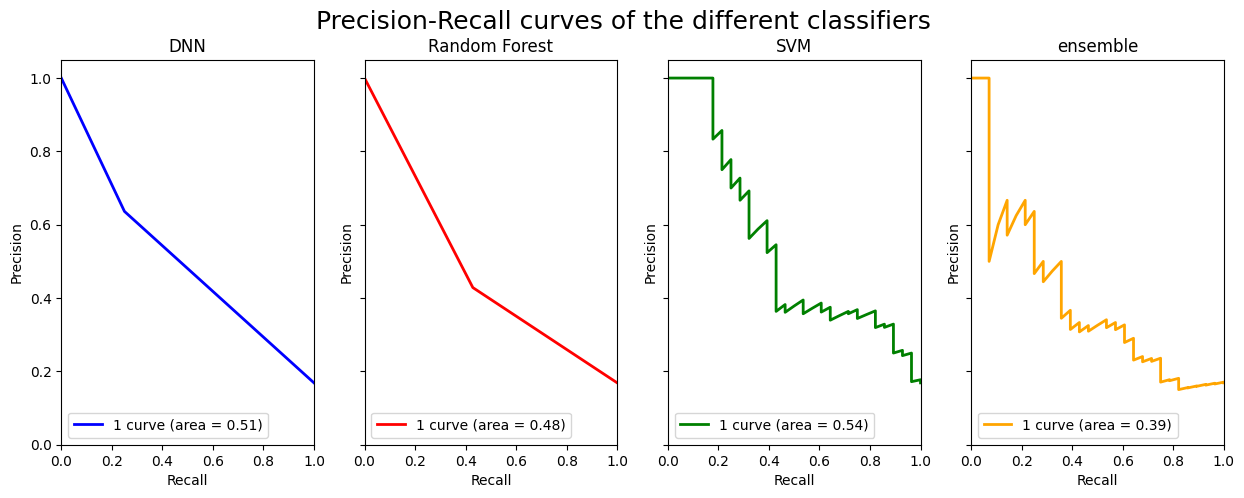

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier

precision_1, recall_1, _ = precision_recall_curve(y_test,final_predictions)
pr_auc_1 = auc(recall_1, precision_1)

precision_2, recall_2, _ = precision_recall_curve(y_test,dnn_predictions_test)
pr_auc_2 = auc(recall_2, precision_2)

precision_3, recall_3, _ = precision_recall_curve(y_test,rf_predictions_test)
pr_auc_3 = auc(recall_3, precision_3)

precision_4, recall_4, _ = precision_recall_curve(y_test,svm_predictions_test)
pr_auc_4 = auc(recall_4, precision_4)

# Plot precision-recall curve
plt.figure()

figs, axs = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)

axs[0].plot(recall_1, precision_1, color='blue', lw=2, label='1 curve (area = %0.2f)' % pr_auc_1)
axs[1].plot(recall_2, precision_2, color='red', lw=2, label='1 curve (area = %0.2f)' % pr_auc_2)
axs[2].plot(recall_3, precision_3, color='green', lw=2, label='1 curve (area = %0.2f)' % pr_auc_3)
axs[3].plot(recall_4, precision_4, color='orange', lw=2, label='1 curve (area = %0.2f)' % pr_auc_4)

#plt.plot(recall_1, precision_1, color='blue', lw=2, label='1 Precision-Recall curve (area = %0.2f)' % pr_auc)

plt.suptitle('Precision-Recall curves of the different classifiers', fontsize=18)
titles= ['DNN', 'Random Forest', 'SVM', 'ensemble']

for i, ax in enumerate(axs):
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.legend(loc="lower left")
    ax.set_title(titles[i])
plt.show()

#ROC curve

<Figure size 640x480 with 0 Axes>

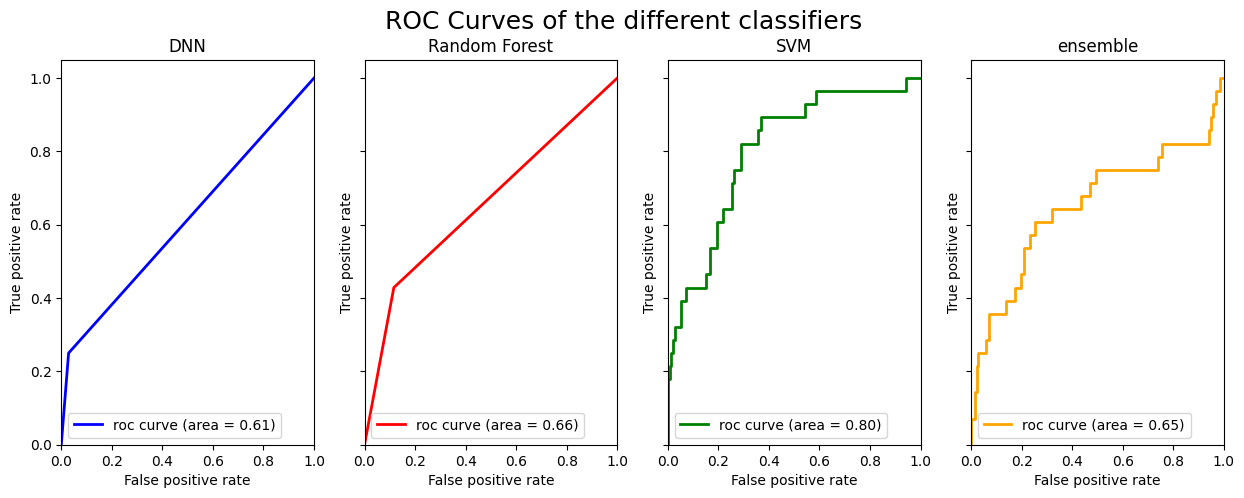

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

fpr_1, tpr_1, _ = roc_curve(y_test,final_predictions)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test,dnn_predictions_test)
roc_auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(y_test,rf_predictions_test)
roc_auc_3 = auc(fpr_3, tpr_3)

fpr_4, tpr_4, _ = roc_curve(y_test,svm_predictions_test)
roc_auc_4 = auc(fpr_4, tpr_4)

# Plot precision-recall curve
plt.figure()

figs, axs = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)

axs[0].plot(fpr_1, tpr_1, color='blue', lw=2, label='roc curve (area = %0.2f)' % roc_auc_1)
axs[1].plot(fpr_2, tpr_2, color='red', lw=2, label='roc curve (area = %0.2f)' % roc_auc_2)
axs[2].plot(fpr_3, tpr_3, color='green', lw=2, label='roc curve (area = %0.2f)' % roc_auc_3)
axs[3].plot(fpr_4, tpr_4, color='orange', lw=2, label='roc curve (area = %0.2f)' % roc_auc_4)

#plt.plot(recall_1, precision_1, color='blue', lw=2, label='1 Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.suptitle('ROC Curves of the different classifiers', fontsize=18)
titles= ['DNN', 'Random Forest', 'SVM', 'ensemble']

for i, ax in enumerate(axs):
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.legend(loc="lower left")
    ax.set_title(titles[i])
plt.show()

#Evaluate deep neural network

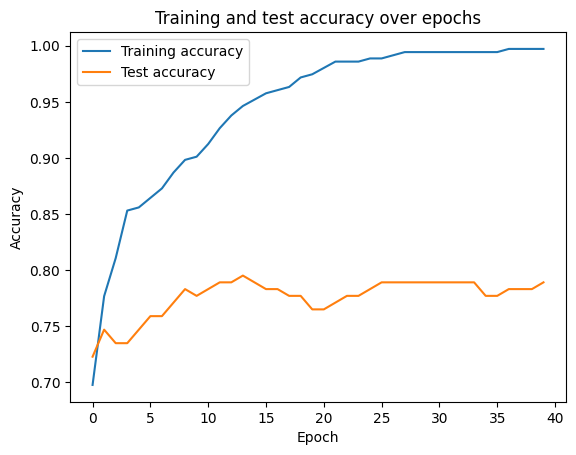

In [ ]:
import matplotlib.pyplot as plt

x_test_selected = selector.transform(x_test)

mlp_test = MLPClassifier(
    hidden_layer_sizes=(100),
    random_state=1,
    learning_rate_init=0.001
)

# The MLPClassifier doesn't automatically log the accuracies during training,
# so we will step through the optimization manually and log the performance
# at each step.
train_scores = []
test_scores = []
n = 40

for i in range(0,n):
    mlp_test.partial_fit(x_train_selected, y_train, np.unique(y_train))
    train_scores.append(mlp_test.score(x_train_selected, y_train))
    test_scores.append(mlp_test.score(x_test_selected, y_test))

plt.title('Training and test accuracy over epochs')
plt.plot(train_scores, label='Training accuracy')
plt.plot(test_scores, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
